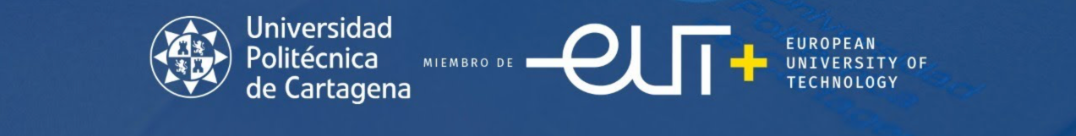

**MACHINE LEARNING II**

# EXAMEN DE PRÁCTICAS <br> TEMA 1 - RAZONAMIENTO PROBABILISTA Y REDES BAYESIANAS


## **Normativa del examen**
- Debe resolver los ejercicios planteados en las celdas de código a continuación del enunciado.
- __SOLAMENTE PUEDE UTILIZAR__ las librerías importadas en la siguiente celda de código.
- __PUEDE__ consultar el material desarrollado en las prácticas.
- Se recomienda __CONTESTAR A TODOS LOS APARTADOS, AUNQUE EL ANTERIOR NO FUNCIONE__, y de esa manera evitar que posibles errores por falta de tiempo le resten puntos inmerecidamente. 
- ESTÁ __TOTALMENTE PROHIBIDO__ EL USO DE APLICACIONES CHAT-GPT, CO-PILOT O SIMILARES. SU USO PUEDE CONLLEVAR A QUE SE CONSIDERE LA PRUEBA DIRECTAMENTE COMO SUSPENSA.
- Una vez terminado el examen, el fichero .ipynb debe ser subido a la correspondiente tarea del Aula Virtual.

In [1]:
# Librerías a utilizar en el examen

%pip install numpy
%pip install pandas
%pip install pgmpy
import numpy as np
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD
from pgmpy.sampling import BayesianModelSampling

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


/home/pyros05/anaconda3/envs/ML_II/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Cuestión 1 - Detección de Melocotones No Aptos para la Venta mediante Prueba de Calidad (5 puntos)

Un productor de fruta realiza un control de calidad para evaluar un cargamento de melocotones. Se ha comprobado que:

- Un **1%** de los melocotones tienen un **riesgo muy bajo** de no ser aptos para la venta.
- Un **6%** tienen una **alta probabilidad** de no ser aptos para la venta.

La prueba de calidad utilizada tiene:

- **Sensibilidad**: 97% → Probabilidad de detectar correctamente un melocotón no apto.
- **Especificidad**: 95% → Probabilidad de identificar correctamente un melocotón apto.

Calcule la probabilidad de que un melocotón no sea apto para la venta dado un resultado positivo en la prueba para cada grupo de riesgo.

Como paso previo a la resolución, será necesario implementar una función que llamaremos prob_no_apto con los datos indicados anteriormente. Esta función deberá tomar como argumento la probabilidad a priori (probabilidades iniciales dadas en el enunciado), la sensibilidad (probabilidad de que un positivo sea defectuoso) y la especificidad (teniendo en cuenta que la probabilidad de que un positivo no sea realmente defectuoso se calcula como 1 - especificidad).


In [4]:
def prob_no_apto(prob_priori: float, sensibilidad: float = 0.97, especificidad: float = 0.95):
    prob_falso_positivo = 1 - especificidad
    num = sensibilidad * prob_priori
    den = num + prob_falso_positivo * (1 - prob_priori)
    if den == 0:
        raise ZeroDivisionError("Probabilidad de que el melocotón no sea apto: 0%")
    return num / den

print("Probabilidad de que un melocotón no sea apto para la venta dado un resultado positivo:")
print(f"- Riesgo muy bajo: {prob_no_apto(prob_priori=0.01)}")
print(f"- Riesgo alto: {prob_no_apto(prob_priori=0.06)}")

Probabilidad de que un melocotón no sea apto para la venta dado un resultado positivo:
- Riesgo muy bajo: 0.16385135135135123
- Riesgo alto: 0.5532319391634978


# Cuestión 2 - Detección de Incendios Forestales con Redes Bayesianas(5 Puntos)

Se ha diseñado una **red bayesiana discreta** para modelar la probabilidad de ocurrencia de un incendio forestal en una zona determinada, considerando factores ambientales y señales de alerta provenientes de sensores, observadores humanos y drones.

---

###  Variables del Modelo

#### **S** – Sensor de temperatura  
- Valores:
  - 0 = No detecta calor anómalo  
  - 1 = Detecta calor anómalo  
- Probabilidades:
  - P(S=0) = 0.98  
  - P(S=1) = 0.02  

#### **H** – Humedad ambiental  
- Valores:
  - 0 = Alta humedad  
  - 1 = Baja humedad  
- Probabilidades:
  - P(H=0) = 0.70  
  - P(H=1) = 0.30  

#### **I** – Incendio  
- Valores:
  - 0 = No hay incendio  
  - 1 = Hay incendio  
- Condicionada por: Sensor (S) y Humedad (H)  
- Probabilidades condicionales:

  - Si S = 0 y H = 0 → P(I=0) = 0.999, P(I=1) = 0.001  
  - Si S = 0 y H = 1 → P(I=0) = 0.950, P(I=1) = 0.050  
  - Si S = 1 y H = 0 → P(I=0) = 0.900, P(I=1) = 0.100  
  - Si S = 1 y H = 1 → P(I=0) = 0.600, P(I=1) = 0.400  

#### **O** – Observador humano  
- Valores:
  - 0 = No reporta humo  
  - 1 = Reporta humo  
- Condicionada por: Incendio (I)  
- Probabilidades condicionales:

  - Si I = 0 → P(O=0) = 0.97, P(O=1) = 0.03  
  - Si I = 1 → P(O=0) = 0.20, P(O=1) = 0.80  

#### **D** – Dron de vigilancia  
- Valores:
  - 0 = No detecta fuego  
  - 1 = Detecta fuego  
- Condicionada por: Incendio (I)  
- Probabilidades condicionales:

  - Si I = 0 → P(D=0) = 0.99, P(D=1) = 0.01  
  - Si I = 1 → P(D=0) = 0.10, P(D=1) = 0.90  

---

###  Obtenga

- La estructura de la red bayesiana
- Las CPDs
- Añada las CPDs al modelo
- La probabilidad de incendio (I=1) dado que S=1 y O=1 utilizando inferencia bayesiana



In [19]:
# Importe las librerías necesarias
import numpy as np
import pandas as pd
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD

# Definición de la red bayesiana
model = DiscreteBayesianNetwork([
    ('S', 'I'), # El valor del sensor condiciona si hay un incendio
    ('H', 'I'), # El nivel de humedad condiciona que haya un incendio
    ('I', 'O'), # Un incendio condiciona que un observador reporte humo
    ('I', 'D')  # Un incendio condiciona que un dron detecte fuego
])

# Definir las CPDs (distribuciones de probabilidad condicional)
cpd_S = TabularCPD(
    variable='S',
    variable_card=2,
    values=[[0.98], [0.02]],
)

cpd_H = TabularCPD(
    variable='H',
    variable_card=2,
    values=[[0.7], [0.3]],
)

cpd_I_dado_S_H = TabularCPD(
    variable='I', 
    variable_card=2,
    values=[
        [0.999, 0.95, 0.9, 0.6],
        [0.001, 0.05, 0.1, 0.4]
    ],
    evidence=['S', 'H'],
    evidence_card=[2, 2]
)

cpd_O_dado_I = TabularCPD(
    variable='O', 
    variable_card=2,
    values=[
        [0.97, 0.20],
        [0.03, 0.80]
    ],
    evidence=['I'],
    evidence_card=[2]
)

cpd_D_dado_I = TabularCPD(
    variable='D', 
    variable_card=2,
    values=[
        [0.99, 0.10],
        [0.01, 0.90]
    ],
    evidence=['I'],
    evidence_card=[2]
)

# Añadir las CPTs al modelo
model.add_cpds(cpd_S, cpd_H, cpd_I_dado_S_H, cpd_O_dado_I, cpd_D_dado_I)

# Validar el modelo
assert model.check_model()

print("✅ El modelo es válido.")

✅ El modelo es válido.


In [21]:
# Crear un objeto de inferencia
infer = VariableElimination(model)
print("🔎 Objeto de inferencia listo.")

# Calcular la probabilidad de incendio dado que S = 1 y O = 1
query_result = infer.query(
    variables=['I'],
    evidence={'S': 1, 'O': 1}
)
print(query_result)
print(f"P(I=1|S=1,O=1) = {query_result.values[1]}")

🔎 Objeto de inferencia listo.
+------+----------+
| I    |   phi(I) |
+======+==========+
| I(0) |   0.1378 |
+------+----------+
| I(1) |   0.8622 |
+------+----------+
P(I=1|S=1,O=1) = 0.8621667612024958
